### Processing of GTEx data and calculation of statistics

In this notebook you can find:
- script for processing GTEx tissue expression data
- calculation of variability statistics
- subsetting statistics for genes with significant SNPs
- and comparison of this statistics for general set and subset

In [129]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
from os import walk
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

### GTEx precessing and calculation of statistics (time consuming)

Execute this block for sake of reproducibility or modification.
Otherwise, in the next block below processed data will imported from file

In [43]:
def calc_range(tpm, samples_n):
    """This function recieves list of tpm for specific gene in file
    and returns range normalized by median.
    Function calculates two variants - 'usual' range
    and 'centered' range for tpm with trimmed 5% values from each end.
    """
    q_05, q_95 = int(samples_n * 0.05 - 1), int(samples_n * 0.95 - 1)  # Indeces of element near 5% and 95% quantiles
    tpm_min, tpm_max, tpm_median = np.min(tpm), np.max(tpm), np.median(tpm)
    tpmc_min, tpmc_max, tpmc_median = np.min(tpmc), np.max(tpmc), np.median(tpmc)
    if tpm_median == 0:
        tpm_range = 0  # To avoid ZeroDivision
    else:
        tpm_range = (tpm_max-tpm_min)/tpm_median
    if tpmc_median == 0:
        tpm_rangec = 0 # To avoid ZeroDivision
    else:
        tpm_rangec = (tpmc_max-tpmc_min)/tpmc_median
    return tpm_range, tpm_rangec


def calc_tissue_stats(ranges_all, rangesc_all):
    """This functions recieves ranges for each tissue and each gene.
    Calculates inter-tissue max range and mean range.
    Returns dataframe with respective stats.
    
    """
    ranges_all_arr = np.array(ranges_all)
    rangesc_all_arr = np.array(rangesc_all)
    
    ranges_mean = ranges_all_arr.mean(axis=0)
    ranges_max = ranges_all_arr.max(axis=0)
    
    rangesc_mean = rangesc_all_arr.mean(axis=0)
    rangesc_max = rangesc_all_arr.max(axis=0)
    
    with open('gene_names.txt') as f:  # Gene names parsed from any GTEx TPM file. Order is preserved
        names = f.readline().split()
    
    tissue_stat_dict = {'names':names, 'ranges_mean':ranges_mean, 'ranges_max':ranges_max,
                        'rangesc_mean':rangesc_mean, 'rangesc_max':rangesc_max}
    tissue_stats = pd.DataFrame(tissue_stat_dict).set_index('names')
    tissue_stats = tissue_stats[(tissue_stats['rangesc_max'] != 0)]
    return tissue_stats

filenames = next(walk('./gtex_tissue/'), (None, None, []))[2]  # [] if no file/ Filenames of per-tissue TPMs

ranges_all, rangesc_all = [], []

print("now is", datetime.now())

for filename in filenames:
    print(filename)
    ranges, rangesc = [],[]

    # Per-tissue tpm data parsing
    with open(f'./gtex_tissue/{filename}') as f:
        f.readline()
        gene_n, samples_n, *_ = list(map(int, f.readline().split()))
        f.readline()
        ranges, rangesc = [],[]
        for line in f:
            _, ids, name, *tpm = line.split()
            tpm = sorted(list(map(float, tpm)))
            tpm_range, tpm_rangec = calc_range(tpm, samples_n)
            ranges += [tpm_range]
            rangesc += [tpm_rangec]
        ranges_all.append(ranges)
        rangesc_all.append(rangesc)
        
print("now is", datetime.now())  # It takes approximately 30-40 minutes with my PC

tissue_stats = calc_tissue_stats(ranges_all, rangesc_all)
tissue_stats.to_csv('tpm_tissue_stats.tsv', sep='\t')

## Working with precomputed stats

In [45]:
tissue_stats = pd.read_csv('tmp_tissue_stats.tsv', sep='\t', index_col='names')
tissue_stats

,ranges_mean,ranges_max,rangesc_mean,rangesc_max
names,,,,
DDX11L1,0.135884,7.337740,0.067357,3.637293
WASH7P,4.249820,13.365275,1.843303,2.491830
MIR1302-2HG,4.967308,53.145251,0.919969,10.858757
OR4G4P,13.334294,59.773014,2.929344,18.812903
OR4G11P,17.203197,56.460177,3.272067,6.275862
...,...,...,...,...
MT-ND6,4.643039,12.596468,2.445661,5.783787
MT-TE,23.092879,162.435784,4.866891,11.532416
MT-CYB,2.026497,9.531497,1.031401,2.121694


#### Subsetting stats for genes with significant SNPs

In [111]:
snp_genes =[]
with open('SNPS_closest_genes.bed') as f:  # Parsing gene names
     for line in f:
        snp_genes += [line.split()[-1]]

for i in range(len(snp_genes)-1, -1, -1):  # Deleting SNP genes with missing expression data
    if snp_genes[i] not in tissue_stats.index:
        del snp_genes[i]
snp_genes = list(set(snp_genes))  # Deduplication


rangesc_mean = []
ranges_mean = []
rangesc_max = []
ranges_max = []
for snp_gene in snp_genes:  # subsetting stats from big table
    rangesc_mean += [tissue_stats.loc[snp_gene,'rangesc_mean']]
    ranges_mean += [tissue_stats.loc[snp_gene,'ranges_mean']]
    rangesc_max += [tissue_stats.loc[snp_gene,'rangesc_max']]
    ranges_max += [tissue_stats.loc[snp_gene,'ranges_max']]
        
snp_gene_stats = pd.DataFrame({'name':snp_genes, 'ranges_mean':ranges_mean,
                       'ranges_max':ranges_max,'rangesc_mean':rangesc_mean,
                       'rangesc_max':rangesc_max}).set_index('name')

snp_gene_stats

,ranges_mean,ranges_max,rangesc_mean,rangesc_max
name,,,,
DAD1,1.868327,4.279072,0.920998,2.058080
SYT10,23.715135,282.875000,5.924153,31.743590
TSC22D4,2.204160,4.586108,1.116311,2.259756
HMGB3P18,0.172080,6.372906,0.110291,3.036321
MYH11,25.169543,160.652200,5.135803,32.529540
...,...,...,...,...
RP4-640H8.2,0.483208,20.223714,0.216525,6.831307
SLC35F1,10.858774,100.421941,3.336122,14.700777
SIPA1L1,2.683402,9.304599,1.264015,2.652400


Ttest_indResult(statistic=2.8065833537201703, pvalue=0.006907539978084667)

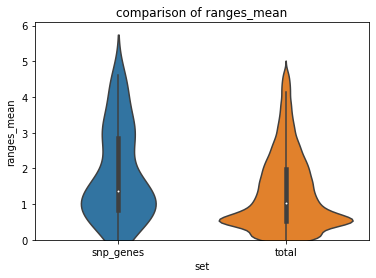

In [140]:
def draw_violin(snp_gene_stats, tissue_stats, feature, trimm=0):
    """This function recieves dataframes with stats
    for SNP genes and alltogether genes, feature for plotting and comparison
    and trimm value. Values in dataframes are sorted by feature and trimmed
    from both sides by trimm value.
    After that values are normalized by range.
    Distribution plots for comparison of variables are plotted.
    t-test for variables with unequal variance is performed.
    Function return t-test result and prints plot.
    
    """
    tissue_stats = tissue_stats.sort_values(by=[feature]).iloc[
        int(trimm*len(tissue_stats)):int((1-trimm)*len(tissue_stats))]
    
    feature_col = tissue_stats.loc[:,feature]
    stand_min = feature_col.min()
    stand_max = feature_col.std()
    tissue_stats.loc[:,feature] = (feature_col-stand_min)/ (stand_max - stand_min)
    
    snp_gene_stats = snp_gene_stats.sort_values(by=[feature]).iloc[
        int(trimm*len(result)):int((1-trimm)*len(result))]
    
    feature_col = snp_gene_stats.loc[:,feature]
    stand_min = feature_col.min()
    stand_max = feature_col.std()
    snp_gene_stats.loc[:,feature] = (feature_col-stand_min)/ (stand_max - stand_min)
    
    # concatenate single columns from dataframes in long format
    comb_df = pd.concat([snp_gene_stats[[feature]].assign(orig='snp_genes'),
                     tissue_stats[[feature]].assign(orig='total')], axis=0)
    
    comb_df = comb_df.rename(columns={'orig':'set'})
    
    ax = sns.violinplot(x='set',y=feature, data=comb_df)
    ax.set(ylim=(0, None))
    plt.title(f'comparison of {feature}')
    ttest_res = scipy.stats.ttest_ind(comb_df.loc[
        comb_df['set'] == 'snp_genes',feature],comb_df.loc[
        comb_df['set'] == 'total',feature],equal_var=False)
    return ttest_res

draw_violin(snp_gene_stats, tissue_stats, 'ranges_mean', trimm=0.1)

Ttest_indResult(statistic=4.308445461975631, pvalue=6.83051521303779e-05)

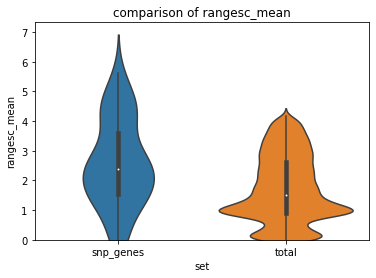

In [141]:
draw_violin(snp_gene_stats, tissue_stats, 'rangesc_mean', trimm=0.1)

Ttest_indResult(statistic=2.8367451782339046, pvalue=0.006365441230775008)

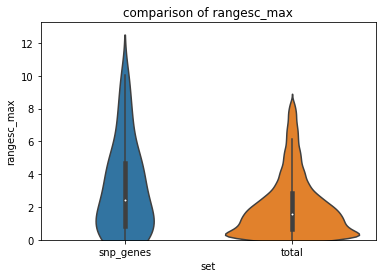

In [142]:
draw_violin(snp_gene_stats, tissue_stats, 'rangesc_max', trimm=0.1)

Ttest_indResult(statistic=1.914976634157551, pvalue=0.060688442698665315)

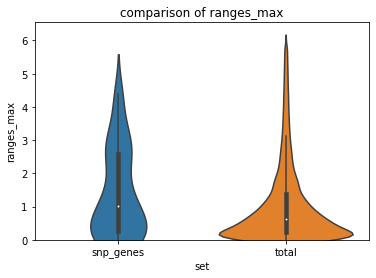

In [146]:
draw_violin(snp_gene_stats, tissue_stats, 'ranges_max', trimm=0.1)